In [6]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import joblib
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from scipy.stats import zscore

import warnings
warnings.filterwarnings('ignore')

In [93]:
fltr=pd.read_excel('Flightticket_train.xlsx',parse_dates=['Arrival_Time'])

In [8]:
fltr.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [10]:
#Checking the datatypes 

fltr.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [11]:
#checking the unique columns
fltr.columns.unique()

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [12]:
#Checking the nulll values
fltr.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [15]:
#viewing the shape of dataset
fltr.shape

(10683, 11)

the feature set consisits of 10683 records with 11 featurs

In [18]:
#checking the null value present in total stops
fltr[fltr['Total_Stops'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


It seems the null value in route is also corresponding to this record

In [19]:
fltra=fltr.copy()

In [20]:
#imputing the null values in both the columns

#finding the mode of route and total stops

print(fltr['Route'].mode())
print(fltr['Total_Stops'].mode())

0    DEL → BOM → COK
dtype: object
0    1 stop
dtype: object


In [21]:
#Either we can drop nan values or impute them with most repeated values

#fltr=fltr.dropna()
#Lets impute the nan values

fltr.loc[9039,'Route']='DEL → BOM → COK'
fltr.loc[9039,'Total_Stops']='1 stop'

In [22]:
fltr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
Airline            10683 non-null object
Date_of_Journey    10683 non-null object
Source             10683 non-null object
Destination        10683 non-null object
Route              10683 non-null object
Dep_Time           10683 non-null object
Arrival_Time       10683 non-null object
Duration           10683 non-null object
Total_Stops        10683 non-null object
Additional_Info    10683 non-null object
Price              10683 non-null int64
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


There is only one int column in the entire dataset

In [23]:
fltr.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [24]:
fltr['Airline'].unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

In [25]:
fltr.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [26]:
fltr['Additional_Info'].unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

In [27]:
fltr['Date_of_Journey'].unique()

array(['24/03/2019', '1/05/2019', '9/06/2019', '12/05/2019', '01/03/2019',
       '24/06/2019', '12/03/2019', '27/05/2019', '1/06/2019',
       '18/04/2019', '9/05/2019', '24/04/2019', '3/03/2019', '15/04/2019',
       '12/06/2019', '6/03/2019', '21/03/2019', '3/04/2019', '6/05/2019',
       '15/05/2019', '18/06/2019', '15/06/2019', '6/04/2019',
       '18/05/2019', '27/06/2019', '21/05/2019', '06/03/2019',
       '3/06/2019', '15/03/2019', '3/05/2019', '9/03/2019', '6/06/2019',
       '24/05/2019', '09/03/2019', '1/04/2019', '21/04/2019',
       '21/06/2019', '27/03/2019', '18/03/2019', '12/04/2019',
       '9/04/2019', '1/03/2019', '03/03/2019', '27/04/2019'], dtype=object)

In [30]:
#converting the date_of_journey into day,month,year
fltr.sort_values('Date_of_Journey',inplace=True)
fltr['year']=pd.DatetimeIndex(fltr['Date_of_Journey']).year
fltr['month']=pd.DatetimeIndex(fltr['Date_of_Journey']).month
fltr['day']=pd.DatetimeIndex(fltr['Date_of_Journey']).day



In [31]:
fltr.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,year,month,day
9848,Air India,01/03/2019,Banglore,New Delhi,BLR → BOM → AMD → DEL,08:50,23:55 02 Mar,39h 5m,2 stops,No info,17135,2019,1,3
6526,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,07:00,09:40,2h 40m,non-stop,No info,21520,2019,1,3
1246,Jet Airways,01/03/2019,Banglore,New Delhi,BLR → BOM → DEL,08:55,16:10,7h 15m,1 stop,No info,26890,2019,1,3
10182,Air India,01/03/2019,Banglore,New Delhi,BLR → BOM → DEL,06:45,12:15,5h 30m,1 stop,No info,23677,2019,1,3
6558,IndiGo,01/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 02 Mar,2h 50m,non-stop,No info,11934,2019,1,3


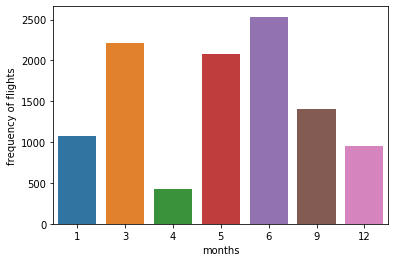

In [33]:
#lets plot the frequency of flights monthly 

sbn.countplot('month',data=fltr)
plt.xlabel('months')
plt.ylabel('frequency of flights')
plt.show()

Most no. of flights are travelled in June month,so it can be considered as peak season..

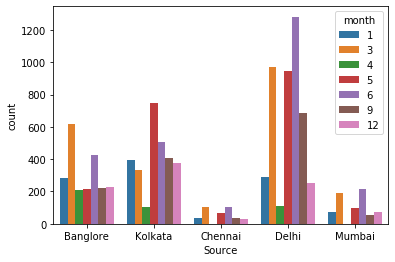

In [41]:
sbn.countplot(x='Source',hue='month',data=fltr)


the frequency of flights at Delhi in June is more when compared to others

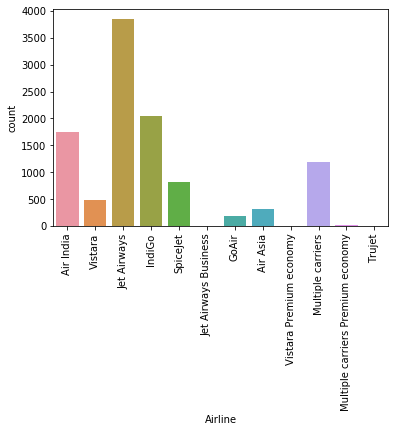

In [45]:
sbn.countplot(x='Airline',data=fltr)
plt.xticks(rotation=90)
plt.show()


Most of the flights are of Jet Airways and trujet,vistara premium economy,multiple carriers premium economy are comparitively negligible

In [46]:
fltr['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [47]:
#Lets check the most busiest destination

fltr['Destination'].value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [48]:
#Lets check the most busiest route 

pd.crosstab(fltr['Source'],fltr['Destination'])

Destination,Banglore,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
Source,,,,,,
Banglore,0,0,1265,0,0,932
Chennai,0,0,0,0,381,0
Delhi,0,4537,0,0,0,0
Kolkata,2871,0,0,0,0,0
Mumbai,0,0,0,697,0,0


The frequency of flights between delhi and cochin is high,so it can be considered as the most busiest route

It is observed that delhi and New delhi are same and can be replaced by Delhi

In [49]:
fltr['Destination'].replace('New Delhi','Delhi',inplace=True)

In [50]:
fltr['Additional_Info'].unique()

array(['No info', 'Change airports', '1 Long layover', 'No Info',
       'Business class', 'Red-eye flight', '1 Short layover',
       '2 Long layover', 'In-flight meal not included',
       'No check-in baggage included'], dtype=object)

It can be observed that no info is repeated and the  types of long layover can be combined.

In [51]:
#Lets replace 1long layover,2 long layover with long layover
#No info with No Info

fltr['Additional_Info'].replace('1 Long layover','Long layover',inplace=True)
fltr['Additional_Info'].replace('2 Long layover','Long layover',inplace=True)
fltr['Additional_Info'].replace('No info','No Info',inplace=True)



In [52]:
pd.crosstab(fltr['Source'],fltr['Destination'])

Destination,Banglore,Cochin,Delhi,Hyderabad,Kolkata
Source,,,,,
Banglore,0,0,2197,0,0
Chennai,0,0,0,0,381
Delhi,0,4537,0,0,0
Kolkata,2871,0,0,0,0
Mumbai,0,0,0,697,0


In [53]:
fltr['Airline'].unique()

array(['Air India', 'Vistara', 'Jet Airways', 'IndiGo', 'SpiceJet',
       'Jet Airways Business', 'GoAir', 'Air Asia',
       'Vistara Premium economy', 'Multiple carriers',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

In [54]:
#Lets combine duplicates of the airlines
fltr['Airline'].replace('Multiple carriers Premium economy','Multiple carriers',inplace=True)
fltr['Airline'].replace('Vistara Premium economy','Vistara',inplace=True)



In [90]:
#As the flight prices are also dependent on the departure time ,lets create the time of day

def time_of_day(p):
    p=p.split(':')
    p=int(p[0])
    if (p >=0 and p <= 2):
        return 'Late Night'
    elif (p >=3 and p <=6):
        return 'Early Morning'
    elif (p >=7 and p <=11):
        return 'Morning'
    elif (p >=12 and p <=16):
        return 'Afternoon'
    elif (p >=17 and p <=20):
        return 'Evening'
    else:
        return 'Night'
    

In [94]:
fltr['dep_time_of_day']=fltr['Dep_Time'].map(time_of_day)

In [95]:
fltr.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,dep_time_of_day
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,2020-03-22 01:10:00,2h 50m,non-stop,No info,3897,Night
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,2020-06-25 13:15:00,7h 25m,2 stops,No info,7662,Early Morning
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,2020-06-10 04:25:00,19h,2 stops,No info,13882,Morning
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,2020-06-25 23:30:00,5h 25m,1 stop,No info,6218,Evening
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,2020-06-25 21:35:00,4h 45m,1 stop,No info,13302,Afternoon


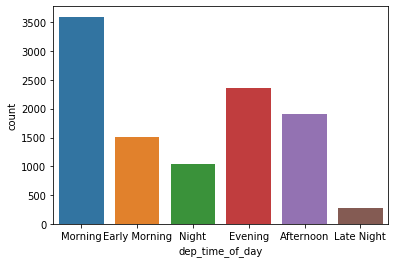

In [59]:
sbn.countplot('dep_time_of_day',data=fltr)

In [97]:
fl=fltr['dep_time_of_day']

Morning flight frequency is comparitively more.

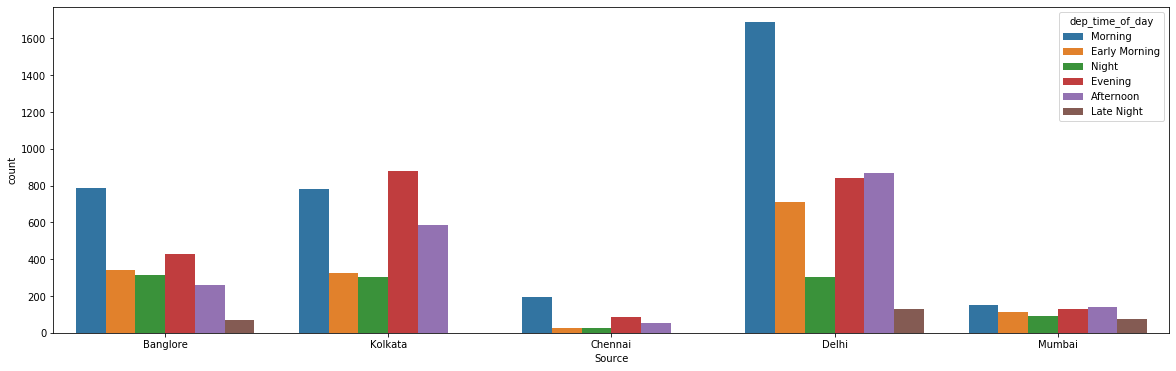

In [60]:
plt.figure(figsize=(20,6))
sbn.countplot('Source',hue='dep_time_of_day',data=fltr)

Delhi being the busiest source and morning flights are more at every source

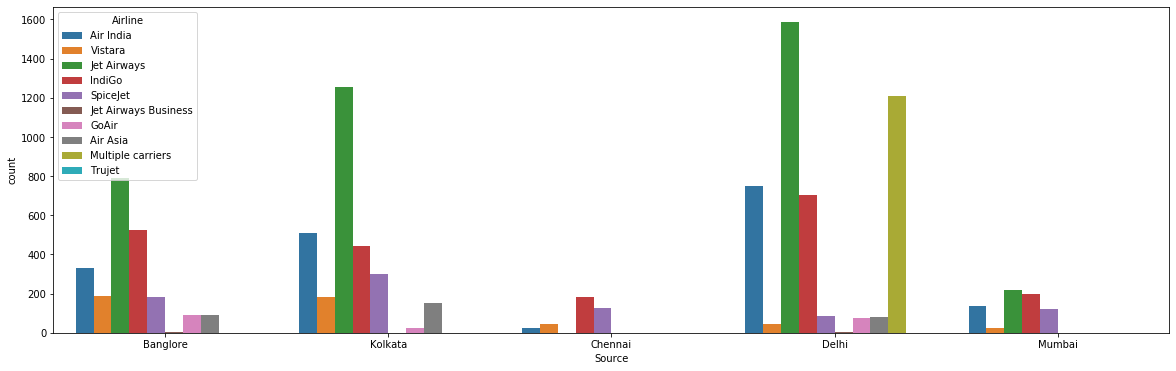

In [61]:
plt.figure(figsize=(20,6))
sbn.countplot('Source',hue='Airline',data=fltr)

In [65]:
#Lets convert the no of stops into integer 

def no_of_stops(x):
    if x=='4 stops':
        return 4
    elif x=='3 stops':
        return 3
    elif x=='2 stops':
        return 2
    elif x=='1 stop':
        return 1
    else:
        return 0     


In [83]:
fltr['no_of_stops']=fltr['Total_Stops'].apply(no_of_stops)

In [84]:
fltr.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Duration_hours,no_of_stops
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,2020-06-25 22:20:00,2020-03-22 01:10:00,2h 50m,non-stop,No info,3897,2.833333,0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,2020-06-25 05:50:00,2020-06-25 13:15:00,7h 25m,2 stops,No info,7662,7.416667,2
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,2020-06-25 09:25:00,2020-06-10 04:25:00,19h,2 stops,No info,13882,19.000000,2
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,2020-06-25 18:05:00,2020-06-25 23:30:00,5h 25m,1 stop,No info,6218,5.416667,1
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,2020-06-25 16:50:00,2020-06-25 21:35:00,4h 45m,1 stop,No info,13302,4.750000,1


In [85]:
fltr.corr()

,Price,Duration_hours,no_of_stops
Price,1.000000,0.450205,0.603891
Duration_hours,0.450205,1.000000,0.591904
no_of_stops,0.603891,0.591904,1.000000


In [69]:
fltr['year'].unique()

array([2019], dtype=int64)

As the year contains only one unique record ,correlation is nan

In [70]:
#Generally, the flight price is also dependent on the duration of flight

fltr['Duration']

9848      39h 5m
6526      2h 40m
1246      7h 15m
10182     5h 30m
6558      2h 50m
          ...   
1504      2h 45m
5909      2h 55m
4921      2h 50m
2047         11h
7297     23h 40m
Name: Duration, Length: 10683, dtype: object

In [73]:
fltr.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'year', 'month', 'day', 'dep_time_of_day',
       'no_of_stops'],
      dtype='object')

In [76]:
#Lets convert duration into float ,in general the flight price is depedent on the duration time

d=(fltr['Arrival_Time']-fltr['Dep_Time'])
dlist=list()
for i in range(len(d)):
    t=d.iloc[i].seconds/3600
    dlist.append(t)
fltr['Duration_hours']=dlist

In [86]:
fltr

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Duration_hours,no_of_stops
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,2020-06-25 22:20:00,2020-03-22 01:10:00,2h 50m,non-stop,No info,3897,2.833333,0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,2020-06-25 05:50:00,2020-06-25 13:15:00,7h 25m,2 stops,No info,7662,7.416667,2
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,2020-06-25 09:25:00,2020-06-10 04:25:00,19h,2 stops,No info,13882,19.000000,2
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,2020-06-25 18:05:00,2020-06-25 23:30:00,5h 25m,1 stop,No info,6218,5.416667,1
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,2020-06-25 16:50:00,2020-06-25 21:35:00,4h 45m,1 stop,No info,13302,4.750000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,2020-06-25 19:55:00,2020-06-25 22:25:00,2h 30m,non-stop,No info,4107,2.500000,0
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,2020-06-25 20:45:00,2020-06-25 23:20:00,2h 35m,non-stop,No info,4145,2.583333,0
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,2020-06-25 08:20:00,2020-06-25 11:20:00,3h,non-stop,No info,7229,3.000000,0
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,2020-06-25 11:30:00,2020-06-25 14:10:00,2h 40m,non-stop,No info,12648,2.666667,0


In [88]:
fltrn=fltr.copy()

In [98]:
fl

0                Night
1        Early Morning
2              Morning
3              Evening
4            Afternoon
             ...      
10678          Evening
10679          Evening
10680          Morning
10681          Morning
10682          Morning
Name: dep_time_of_day, Length: 10683, dtype: object

In [102]:
fin=pd.concat([fltrn,fl],axis=1)

In [103]:
fin

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Duration_hours,no_of_stops,dep_time_of_day
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,2020-06-25 22:20:00,2020-03-22 01:10:00,2h 50m,non-stop,No info,3897,2.833333,0,Night
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,2020-06-25 05:50:00,2020-06-25 13:15:00,7h 25m,2 stops,No info,7662,7.416667,2,Early Morning
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,2020-06-25 09:25:00,2020-06-10 04:25:00,19h,2 stops,No info,13882,19.000000,2,Morning
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,2020-06-25 18:05:00,2020-06-25 23:30:00,5h 25m,1 stop,No info,6218,5.416667,1,Evening
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,2020-06-25 16:50:00,2020-06-25 21:35:00,4h 45m,1 stop,No info,13302,4.750000,1,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,2020-06-25 19:55:00,2020-06-25 22:25:00,2h 30m,non-stop,No info,4107,2.500000,0,Evening
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,2020-06-25 20:45:00,2020-06-25 23:20:00,2h 35m,non-stop,No info,4145,2.583333,0,Evening
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,2020-06-25 08:20:00,2020-06-25 11:20:00,3h,non-stop,No info,7229,3.000000,0,Morning
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,2020-06-25 11:30:00,2020-06-25 14:10:00,2h 40m,non-stop,No info,12648,2.666667,0,Morning


In [105]:
fin.dtypes

Airline                    object
Date_of_Journey            object
Source                     object
Destination                object
Route                      object
Dep_Time           datetime64[ns]
Arrival_Time       datetime64[ns]
Duration                   object
Total_Stops                object
Additional_Info            object
Price                       int64
Duration_hours            float64
no_of_stops                 int64
dep_time_of_day            object
dtype: object

In [108]:
fin=fin.dropna()

In [109]:
fin.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
Duration_hours     0
no_of_stops        0
dep_time_of_day    0
dtype: int64

In [111]:
finq=fin.copy()

In [112]:
#Removing the features which are not helpful
fin=fin.drop(['Duration','Total_Stops','Route'],axis=1)

In [113]:
fin

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Additional_Info,Price,Duration_hours,no_of_stops,dep_time_of_day
0,IndiGo,24/03/2019,Banglore,New Delhi,2020-06-25 22:20:00,2020-03-22 01:10:00,No info,3897,2.833333,0,Night
1,Air India,1/05/2019,Kolkata,Banglore,2020-06-25 05:50:00,2020-06-25 13:15:00,No info,7662,7.416667,2,Early Morning
2,Jet Airways,9/06/2019,Delhi,Cochin,2020-06-25 09:25:00,2020-06-10 04:25:00,No info,13882,19.000000,2,Morning
3,IndiGo,12/05/2019,Kolkata,Banglore,2020-06-25 18:05:00,2020-06-25 23:30:00,No info,6218,5.416667,1,Evening
4,IndiGo,01/03/2019,Banglore,New Delhi,2020-06-25 16:50:00,2020-06-25 21:35:00,No info,13302,4.750000,1,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,2020-06-25 19:55:00,2020-06-25 22:25:00,No info,4107,2.500000,0,Evening
10679,Air India,27/04/2019,Kolkata,Banglore,2020-06-25 20:45:00,2020-06-25 23:20:00,No info,4145,2.583333,0,Evening
10680,Jet Airways,27/04/2019,Banglore,Delhi,2020-06-25 08:20:00,2020-06-25 11:20:00,No info,7229,3.000000,0,Morning
10681,Vistara,01/03/2019,Banglore,New Delhi,2020-06-25 11:30:00,2020-06-25 14:10:00,No info,12648,2.666667,0,Morning


In [114]:
x=fin.drop('Price',axis=1)

In [115]:
x.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Additional_Info,Duration_hours,no_of_stops,dep_time_of_day
0,IndiGo,24/03/2019,Banglore,New Delhi,2020-06-25 22:20:00,2020-03-22 01:10:00,No info,2.833333,0,Night
1,Air India,1/05/2019,Kolkata,Banglore,2020-06-25 05:50:00,2020-06-25 13:15:00,No info,7.416667,2,Early Morning
2,Jet Airways,9/06/2019,Delhi,Cochin,2020-06-25 09:25:00,2020-06-10 04:25:00,No info,19.000000,2,Morning
3,IndiGo,12/05/2019,Kolkata,Banglore,2020-06-25 18:05:00,2020-06-25 23:30:00,No info,5.416667,1,Evening
4,IndiGo,01/03/2019,Banglore,New Delhi,2020-06-25 16:50:00,2020-06-25 21:35:00,No info,4.750000,1,Afternoon


In [122]:
y=pd.DataFrame(columns=['Price'],data=fin)

In [123]:
y.head()

,Price
0,3897
1,7662
2,13882
3,6218
4,13302


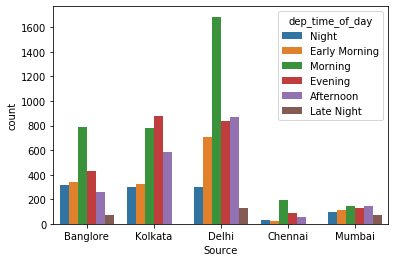

In [124]:
#EDA..

sbn.countplot('Source',hue='dep_time_of_day',data=fin)

Morning flight frequency is more than any other time of day

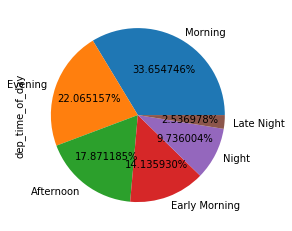

In [154]:
fin['dep_time_of_day'].value_counts().plot(kind='pie',autopct='%1f%%')

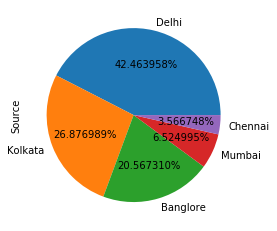

In [155]:
fin['Source'].value_counts().plot(kind='pie',autopct='%1f%%')

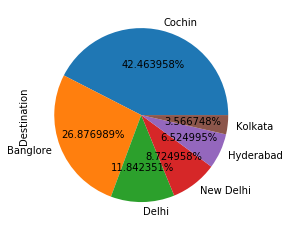

In [157]:
fin['Destination'].value_counts().plot(kind='pie',autopct='%1f%%')

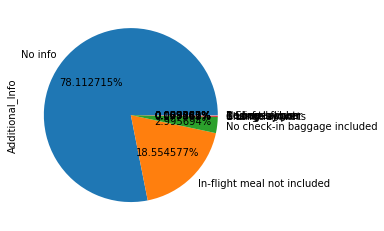

In [158]:
fin['Additional_Info'].value_counts().plot(kind='pie',autopct='%1f%%')

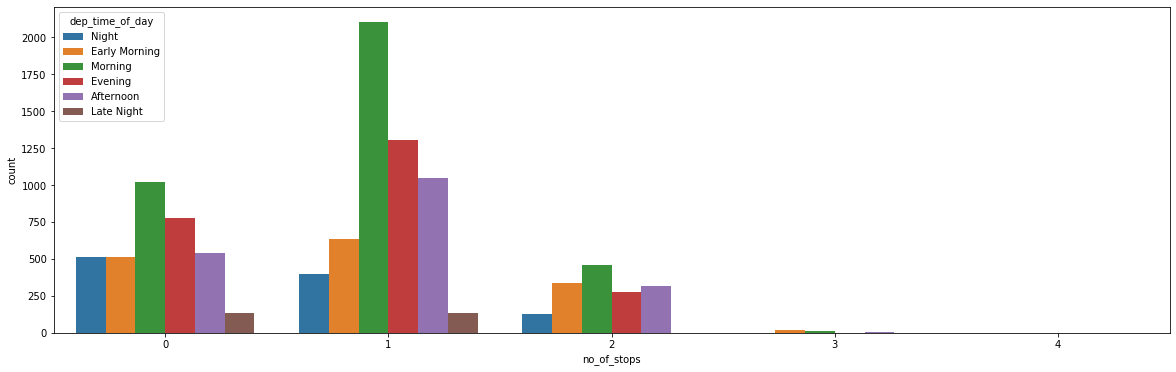

In [128]:
plt.figure(figsize=(20,6))
sbn.countplot('no_of_stops',hue='dep_time_of_day',data=fin)

Flight frequency with single stop is high

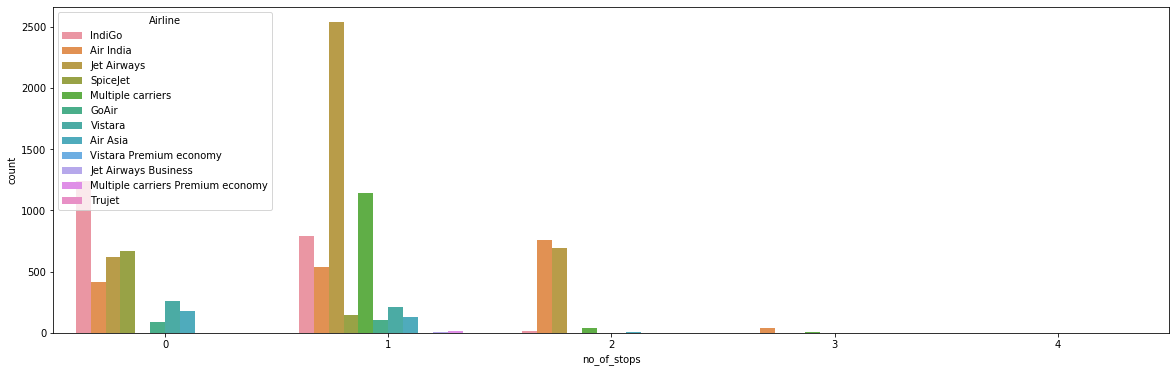

In [129]:
plt.figure(figsize=(20,6))
sbn.countplot('no_of_stops',hue='Airline',data=fin)

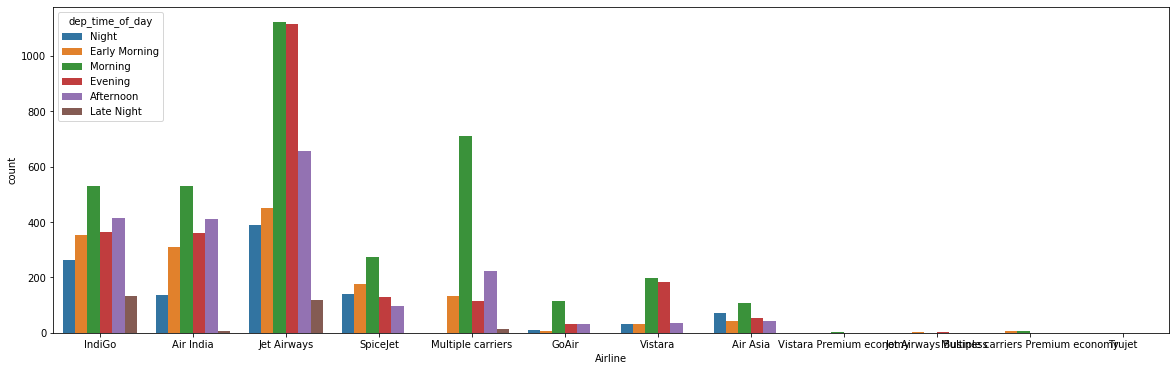

In [130]:
plt.figure(figsize=(20,6))
sbn.countplot('Airline',hue='dep_time_of_day',data=fin)

JetAirways flight frequency is high and most of them are morning departed flights

In [141]:
#Lets check the minimum price of the ticket,with whole record
fin.loc[fin['Price'].idxmin()]

Airline                       SpiceJet
Date_of_Journey             21/03/2019
Source                          Mumbai
Destination                  Hyderabad
Dep_Time           2020-06-25 22:45:00
Arrival_Time       2020-03-22 00:10:00
Additional_Info                No info
Price                             1759
Duration_hours                 1.41667
no_of_stops                          0
dep_time_of_day                  Night
Name: 4066, dtype: object

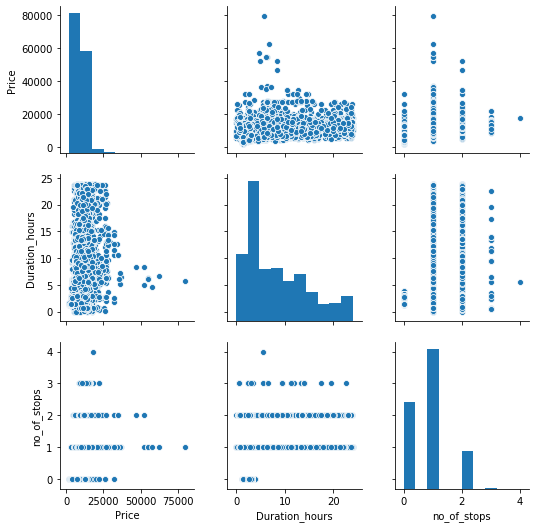

In [145]:
sbn.pairplot(fin)

In [146]:
#Encoding the object columns in the features

x=pd.get_dummies(x,drop_first=True)

In [148]:
y.head()

,Price
0,3897
1,7662
2,13882
3,6218
4,13302


In [152]:
x=x.drop(['Arrival_Time','Dep_Time'],axis=1)

In [153]:
#Bringing the features to common scale

sc=StandardScaler()
x=pd.DataFrame(sc.fit_transform(x))

In [159]:
def r2score(model,x,y):
    max_acc=0
    for rst in range(40,100):
        x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=rst,test_size=.22)
        model.fit(x_train,y_train)
        predy=model.predict(x_test)
        acc=r2_score(y_test,predy)
        print('Accuracy is',acc,'for the random state',rst)
        if acc>max_acc:
            max_acc=acc
            f_rst=rst
    print('Maximum r2score is ',max_acc,'and acquired at',f_rst)
    return f_rst

In [160]:
dtr=DecisionTreeRegressor()
params={'criterion': ['mse'],
 'max_depth': [None],
 'max_features': [None],
 'max_leaf_nodes': [4,8,16],
 'min_impurity_decrease': [0.0],
 'min_impurity_split': [None],
 'min_samples_leaf': [1,2,4],
 'min_samples_split': [2,4],
 'min_weight_fraction_leaf': [0.0],
 'presort': [False],
 'random_state': [None],
 'splitter': ['best']}


In [161]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.22,random_state=45)
from sklearn.model_selection import GridSearchCV
gcv=GridSearchCV(estimator=dtr,param_grid=params)
gcv.fit(x_train,y_train)
gcv.best_params_

{'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': 16,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [162]:
dtr=DecisionTreeRegressor(criterion='mse',
 max_leaf_nodes=16,
 min_impurity_decrease=0.0,
 min_samples_leaf= 1,
 min_samples_split=2,
 splitter='best')
dtr.fit(x_train,y_train)
dtrpr=dtr.predict(x_test)
print('Mean Absolute Error:',mean_absolute_error(y_test,dtrpr))
print('Mean Squared Error:',mean_squared_error(y_test,dtrpr))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,dtrpr)))
print('R2 sCcore is:',r2_score(y_test,dtrpr))

Mean Absolute Error: 1706.2363266988662
Mean Squared Error: 7695400.63103058
Root Mean Squared Error: 2774.058512546298
R2 sCcore is: 0.6508665461254843


In [163]:
model=GradientBoostingRegressor()
model.fit(x_train,y_train)
predm=model.predict(x_test)
print('mean r2 score for gradient boosting regressor is',cross_val_score(model,x_train,y_train,cv=5,scoring='r2').mean())

mean r2 score for gradient boosting regressor is 0.7924939263274011


In [164]:
Lr=LinearRegression()
r2score(Lr,x,y)

Accuracy is 0.7434357902210107 for the random state 40
Accuracy is 0.7383505000504929 for the random state 41
Accuracy is 0.7880947520947654 for the random state 42
Accuracy is 0.80696646728172 for the random state 43
Accuracy is -4.93303410455725e+25 for the random state 44
Accuracy is -2.8693167540486506e+21 for the random state 45
Accuracy is -1.0347022599021506e+21 for the random state 46
Accuracy is 0.7396097963610497 for the random state 47
Accuracy is 0.7602613220737584 for the random state 48
Accuracy is 0.7715530538548159 for the random state 49
Accuracy is 0.752974094444254 for the random state 50
Accuracy is 0.8040785381828133 for the random state 51
Accuracy is 0.7558271611134164 for the random state 52
Accuracy is -1.0205052362174279e+22 for the random state 53
Accuracy is 0.7747006410774017 for the random state 54
Accuracy is -1.620747803307889e+21 for the random state 55
Accuracy is 0.7787732938708988 for the random state 56
Accuracy is -1.2027691877331832e+20 for the ra

75

In [165]:
r2score(dtr,x,y)

Accuracy is 0.6793162619110246 for the random state 40
Accuracy is 0.6359494917099878 for the random state 41
Accuracy is 0.7358786064624648 for the random state 42
Accuracy is 0.7549224650000732 for the random state 43
Accuracy is 0.722804174022051 for the random state 44
Accuracy is 0.6508665461254843 for the random state 45
Accuracy is 0.6920852765639347 for the random state 46
Accuracy is 0.6864336512348568 for the random state 47
Accuracy is 0.6903213715410988 for the random state 48
Accuracy is 0.691918909513764 for the random state 49
Accuracy is 0.6745176131131766 for the random state 50
Accuracy is 0.7322906780492882 for the random state 51
Accuracy is 0.6833110246407226 for the random state 52
Accuracy is 0.6749317020478867 for the random state 53
Accuracy is 0.6688600159463557 for the random state 54
Accuracy is 0.6637223776746128 for the random state 55
Accuracy is 0.6958925766901248 for the random state 56
Accuracy is 0.7434273085997685 for the random state 57
Accuracy is 

79

In [166]:
rfr=RandomForestRegressor()
r2score(rfr,x,y)

Accuracy is 0.8164059878241332 for the random state 40
Accuracy is 0.8233116099958483 for the random state 41
Accuracy is 0.8773247829078317 for the random state 42
Accuracy is 0.8846279169428305 for the random state 43
Accuracy is 0.8702542968565592 for the random state 44
Accuracy is 0.7984219926212108 for the random state 45
Accuracy is 0.8660591532290962 for the random state 46
Accuracy is 0.8010575621846795 for the random state 47
Accuracy is 0.8420720754440493 for the random state 48
Accuracy is 0.8245283855673113 for the random state 49
Accuracy is 0.8096176021200996 for the random state 50
Accuracy is 0.8824075803939164 for the random state 51
Accuracy is 0.8354091722061253 for the random state 52
Accuracy is 0.847966150069895 for the random state 53
Accuracy is 0.8488250554979093 for the random state 54
Accuracy is 0.799951965252167 for the random state 55
Accuracy is 0.8409263305214228 for the random state 56
Accuracy is 0.8584464072248563 for the random state 57
Accuracy is 

79

In [167]:
knr=KNeighborsRegressor()
parameters={'n_neighbors':[10,100,300,500]}
gcv=GridSearchCV(estimator=knr,param_grid=parameters)
gcv.fit(x_train,y_train)
print(gcv.best_params_)
print(gcv.best_score_)

{'n_neighbors': 10}
0.7178117806283367


In [173]:
#As Random forest is performing well than others ,fitting it as final model

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.22,random_state=79)
rf=RandomForestRegressor()
rf.fit(x_train,y_train)
rfp=rf.predict(x_test)
print('Mean Absolute Error:',mean_absolute_error(y_test,rfp))
print('Mean Squared Error:',mean_squared_error(y_test,rfp))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,rfp)))
print('R2 score is:',r2_score(y_test,rfp))

Mean Absolute Error: 791.0410618075388
Mean Squared Error: 2453375.772867839
Root Mean Squared Error: 1566.3255641366002
R2 score is: 0.8888045759833665


In [172]:
#Cross validating the performance of the rfregressor..

cvs=cross_val_score(rf,x,y,cv=5,scoring='r2')
print('mean accuracy of random forest regression is ',cvs.mean())
print('Standard deviation of the model is ',cvs.std())

mean accuracy of random forest regression is  0.8549778600203595
Standard deviation of the model is  0.008596745618177089


As the random forest regressor is performing well than other models,considering this model to be as a best fit

In [174]:
#Saving predictions and the model
prdct=pd.DataFrame(rfp,columns=['Price'])
prdct=prdct.to_csv('flighttktpricepredictions.csv',index=False)

In [175]:
#Saving the model
import joblib
joblib.dump(rf,'flight_tkt_pred.pkl')

['flight_tkt_pred.pkl']